In [1]:
import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib
from threading import Thread
import imutils

# Function that returns the distance between two given points
def ptDist(pt1, pt2):
    x1 = pt1[0]
    x2 = pt2[0]
    y1 = pt1[1]
    y2 = pt2[1]
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2)) 

def get17LMA(img, predictor, detector):
    LMA = []
    
    # Detect face(s)
    dets = detector(img, 1)

    # Get list of coordinates of 68 facial landmarks for each face
    if len(dets)>0:
        shape = predictor(img, dets[0])
        for index in range(0, 17):
            point = shape.part(index)
            tuplepoint = (point.x, point.y)
            LMA.append(tuplepoint)
        return LMA
    else:
        return None
    
def getPhysDA(iLA):
    PDA = []
    PDA.append(ptDist(iLA[2], iLA[3])) #distance 0: distance between brows
    PDA.append(ptDist(iLA[2], iLA[4])) #distance 1: inner brow to nose- left
    PDA.append(ptDist(iLA[3], iLA[4])) #distance 2: inner brow to nose- right
    PDA.append(ptDist(iLA[2], iLA[6])) #distance 3: inner brow to inner eye corner- left
    PDA.append(ptDist(iLA[3], iLA[7])) #distance 4: inner brow to inner eye corner- right
    PDA.append(ptDist(iLA[5], iLA[11])) #distance 5: outer eye corner to outer mouth corner- left
    PDA.append(ptDist(iLA[8], iLA[12])) #distance 6: outer eye corner to outer mouth corner- right
    PDA.append(ptDist(iLA[11], iLA[12])) #distance 7: distance between mouth corners
    PDA.append(ptDist(iLA[15], iLA[16])) #distance 8: height of mouth
    PDA.append(ptDist(iLA[5], iLA[13])) #distance 9: raising of upper lip
    PDA.append(ptDist(iLA[7], iLA[14])) #distance 10: raising of upper lip
    PDA.append(ptDist(iLA[0], iLA[9])) #distance 11: brow arch- left
    PDA.append(ptDist(iLA[1], iLA[10])) #distance 12: brow arch- right
    return np.asarray(PDA)
    
class WebcamVideoStream:
    def __init__(self, src=0):
        # initialize the video camera stream and read the first frame
        # from the stream
        self.stream = cv2.VideoCapture(src)
        (self.grabbed, self.frame) = self.stream.read()
 
        # initialize the variable used to indicate if the thread should
        # be stopped
        self.stopped = False
    def start(self):
        # start the thread to read frames from the video stream
        Thread(target=self.update, args=()).start()
        return self
 
    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                return
 
            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()
 
    def read(self):
        # return the frame most recently read
        return self.frame
 
    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True

In [2]:
def browTrain(IB, bV, label, RL, predictor, detector, vs):
    B_ANGLE = IB
    baseVector = bV
    STEP = 4
    N_REWARD = 0
    L_REWARD = 0
    NB = 0
    GRAD_SIGN = 1
    polyCLF = joblib.load('theModel.pkl')
    RList = RL
    
    """CALCULATE INITIAL LOSS"""
    # Initialize ARGO Face
    !ssh pi@192.168.1.119 "echo 6=$B_ANGLE > /dev/servoblaster"
    !ssh pi@192.168.1.119 "echo 3=$L_ANGLE > /dev/servoblaster"
    !ssh pi@192.168.1.119 "echo 4=$R_ANGLE > /dev/servoblaster"

    # Capture and display frame with 17 landmarks
    lm1 = None
    while lm1 == None:
        brow1 = vs.read()
        brow1 = imutils.resize(brow1, width=400)
        lm1 = get17LMA(brow1, predictor, detector)
    for i in range(17):
            cv2.circle(brow1, (lm1[i][0], lm1[i][1]), 2, (0, 0, 255), -1)
    cv2.imshow('brow1',brow1)

    # Get probabilities
    prediction = polyCLF.predict_proba(np.asarray(baseVector-getPhysDA(lm1)).reshape(1,-1))
    
    # Calculate loss
    L_REWARD = prediction[0][label]
    RList.append(L_REWARD)
    
    """TRAIN ITERATIVELY TO MAXIMIZE REWARD"""
    for j in range(0, 20):
        # Adjust step and angle
        if j==10:
            STEP=STEP/2
        if j==15:
            STEP=STEP/2
        if STEP < 1:
            STEP = 1
        NB = B_ANGLE + STEP*GRAD_SIGN
        !ssh pi@192.168.1.119 "echo 6=$NB > /dev/servoblaster"

        # Get image
        lm2 = None
        while lm2 == None:
            brow2 = vs.read()
            brow2 = imutils.resize(brow2, width=400)
            lm2 = get17LMA(brow2, predictor, detector)
        for i in range(17):
                cv2.circle(brow2, (lm2[i][0], lm2[i][1]), 2, (0, 0, 255), -1)
        cv2.imshow('brow2',brow2)
        
        # Get probabilities
        prediction = polyCLF.predict_proba(np.asarray(baseVector-getPhysDA(lm2)).reshape(1,-1))

        # Calculate loss
        N_REWARD = prediction[0][label]
        print(prediction[0])
        
        # Adjust for next iteration
        GRAD_SIGN = int(np.sign((N_REWARD-L_REWARD)/STEP))
        L_REWARD=N_REWARD
        RList.append(L_REWARD)
        B_ANGLE = NB
    return B_ANGLE, L_REWARD, RList



def mouthTrain(IL, IR, bV, label, L_REW, RL, predictor, detector, vs):
    L_ANGLE = IL
    R_ANGLE = IR
    baseVector = bV
    STEP = 4
    N_REWARD = 0
    L_REWARD = L_REW
    NL = 0
    NR = 0
    GRAD_SIGN = 1
    polyCLF = joblib.load('theModel.pkl')
    RList = RL

    for j in range(0, 20): 
        # Adjust step and angle
        if j==10:
            STEP=STEP/2
        if j==15:
            STEP=STEP/2
        if STEP < 1:
            STEP = 1
        NL = L_ANGLE + STEP*GRAD_SIGN
        NR = R_ANGLE - STEP*GRAD_SIGN
        !ssh pi@192.168.1.119 "echo 3=$L_ANGLE > /dev/servoblaster"
        !ssh pi@192.168.1.119 "echo 4=$R_ANGLE > /dev/servoblaster"

        # Get image
        lm3 = None
        while lm3 == None:
            mouth = vs.read()
            mouth = imutils.resize(mouth, width=400)
            lm3 = get17LMA(mouth, predictor, detector)
        for i in range(17):
                cv2.circle(mouth, (lm3[i][0], lm3[i][1]), 2, (0, 0, 255), -1)
        cv2.imshow('mouth',mouth)

        
        # Get probabilities
        prediction = polyCLF.predict_proba(np.asarray(baseVector-getPhysDA(lm3)).reshape(1,-1))
        
        # Calculate loss
        N_REWARD = prediction[0][label]
        print(prediction[0])
        
        # Adjust for next iteration
        GRAD_SIGN = int(np.sign((N_REWARD-L_REWARD)/STEP))
        L_REWARD=N_REWARD
        RList.append(L_REWARD)
        L_ANGLE = NL
        R_ANGLE = NR

#     cv2.destroyAllWindows()
    return L_ANGLE, R_ANGLE, L_REWARD, RList

In [3]:
###### TRAINING THE GENERATIVE MODEL ######
# 
#
#  ANGER TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib

"""Initialize Variables"""
B_ANGLE = 160
L_ANGLE = 100
R_ANGLE = 170
L_REWARD = 0
InitRew_List = []

predictor_path = "/Users/kaili/dlib/examples/build/sp.dat"
detector = dlib.fhog_object_detector("/Users/kaili/dlib/examples/build/face_detector.svm")
predictor = dlib.shape_predictor(predictor_path)


#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
bvec = None
while bvec == None:
    baseline = vs.read()
    baseline = imutils.resize(baseline, width=640)
    bvec = get17LMA(baseline,predictor,detector)
baseVector = getPhysDA(bvec)


############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 0, InitRew_List, predictor, detector, vs)
print("browsdone")

############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 0, L_REWARD, InitRew_List, predictor, detector, vs)

############
# CLEANUP AND RESULTS
############
vs.stop()
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Anger All Rewards: ")
print(Rew_List)



[  9.93992015e-01   8.40367294e-05   1.76361343e-04   4.20221822e-05
   5.51994422e-03   1.43574374e-04   4.20459969e-05]
[  9.93980964e-01   8.57762025e-05   1.39419978e-04   4.30117858e-05
   5.57129361e-03   1.36540865e-04   4.29930644e-05]
[  9.97766364e-01   1.34766150e-05   2.30119865e-05   6.77532738e-06
   2.15835024e-03   2.52652988e-05   6.75604370e-06]
[  9.93923213e-01   8.73135323e-05   1.41732623e-04   4.37809662e-05
   5.62183603e-03   1.38355740e-04   4.37683383e-05]
[  9.97359601e-01   1.85475961e-05   3.40501919e-05   9.29800866e-06
   2.53660859e-03   3.26036253e-05   9.29090047e-06]
[  9.94243429e-01   7.84578339e-05   1.59000785e-04   3.92497501e-05
   5.31362626e-03   1.26909303e-04   3.93273553e-05]
[  9.97385179e-01   1.82028574e-05   3.35197053e-05   9.12552404e-06
   2.51269245e-03   3.21622343e-05   9.11801306e-06]
[  9.94960196e-01   6.28416168e-05   1.16334471e-04   3.14111064e-05
   4.70958251e-03   8.80657057e-05   3.15681111e-05]
[  9.94279356e-01   7.76

In [4]:

print(Rew_List)

[0.92442519480429364, 0.99399201515257662, 0.99398096449485318, 0.99776636449020362, 0.99392321276927564, 0.99735960108603672, 0.99424342871373705, 0.99738517921715486, 0.994960196477781, 0.99427935591339922, 0.99738517921715486, 0.99142439625654044, 0.99392321276927564, 0.98429721289862182, 0.99398096449485318, 0.99285324758579419, 0.99392321276927564, 0.99392321276927564, 0.98429721289862182, 0.99392321276927564, 0.99287928484448962, 0.99720106234195949, 0.9904245030055967, 0.99566328642862756, 0.98011604692928489, 0.99292140874313051, 0.98968727897971609, 0.99285324758579419, 0.9854850651513124, 0.98654876068959174, 0.99247121870909838, 0.99389649215724329, 0.99147560267461843, 0.98983146678283462, 0.99555965464731444, 0.99720718304040945, 0.98374418366718352, 0.98998528133898878, 0.99544865337835009, 0.99391083651838885, 0.99676399580223896]


In [9]:
import json
with open("AngerRewards","w") as wfile:
    json.dump(Rew_List,wfile)

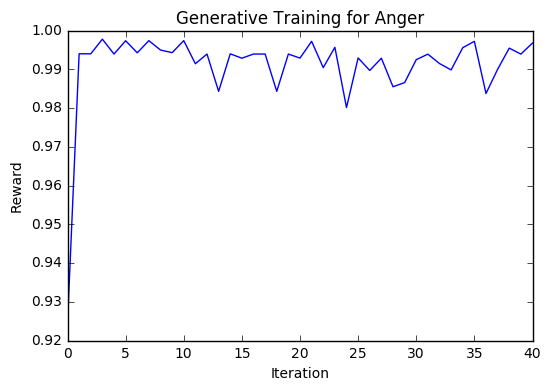

In [14]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,41)

plt.plot(x, Rew_List)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Generative Training for Anger")
plt.savefig("ARewT.png")
plt.show()

In [ ]:
###### TRAINING THE GENERATIVE MODEL ######
#
#  HAPPINESS TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib


"""Load SVM"""
polyCLF = joblib.load('theModel.pkl')

"""Initialize Variables"""
B_ANGLE = 100
L_ANGLE = 175
R_ANGLE = 90
L_REWARD = 0
InitRew_List = []

#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
baseline = vs.read()
baseline = imutils.resize(baseline, width=400)
baseVector = getPhysDA(get17LMA(baseline))
vs.stop()

############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 4, InitRew_List)


############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 4, L_REWARD, InitRew_List)

############
# CLEANUP AND RESULTS
############
cv2.destroyAllWindows()
cv2.waitKey(1)
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Happiness All Rewards: " + Rew_List)


In [ ]:
###### TRAINING THE GENERATIVE MODEL ######
# 
#
#  SADNESS TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib


"""Load SVM"""
polyCLF = joblib.load('theModel.pkl')

"""Initialize Variables"""
B_ANGLE = 100
L_ANGLE = 100
R_ANGLE = 170
L_REWARD = 0
InitRew_List = []

#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
baseline = vs.read()
baseline = imutils.resize(baseline, width=400)
baseVector = getPhysDA(get17LMA(baseline))
vs.stop()

############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 5, InitRew_List)


############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 5, L_REWARD, InitRew_List)

############
# CLEANUP AND RESULTS
############
cv2.destroyAllWindows()
cv2.waitKey(1)
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Sadness All Rewards: " + Rew_List)

In [ ]:
###### TRAINING THE GENERATIVE MODEL ######
# 
#
#  SURPRISE TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib


"""Load SVM"""
polyCLF = joblib.load('theModel.pkl')

"""Initialize Variables"""
B_ANGLE = 100
L_ANGLE = 120
R_ANGLE = 140
L_REWARD = 0
InitRew_List = []

#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
baseline = vs.read()
baseline = imutils.resize(baseline, width=400)
baseVector = getPhysDA(get17LMA(baseline))
vs.stop()

############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 6, InitRew_List)


############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 6, L_REWARD, InitRew_List)

############
# CLEANUP AND RESULTS
############
cv2.destroyAllWindows()
cv2.waitKey(1)
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Surprise All Rewards: " + Rew_List)

In [1]:
!ssh pi@192.168.1.119 "echo 6=$165 > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$100 > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$160 > /dev/servoblaster"